In [8]:
from robust_gcn_structure.certification import certify
from robust_gcn_structure.utils import load_npz
from matplotlib import pyplot as plt
import torch

In [2]:
dataset = "citeseer"
robust_gcn = True  # Whether to load weights for GCN trained with the approach by [Zügner and Günnemann 2019

local_budget = 3
global_budget = 5

In [3]:
target_node = 3311
eval_class = 0

In [4]:
solver = "ECOS"
max_iters = 250
tolerance = 1e-2
kwargs = {
    'tolerance': tolerance,
    'max_iter': max_iters
}

In [5]:
A, X, z = load_npz(f'../datasets/{dataset}.npz')
A = A + A.T
A[A > 1] = 1
A.setdiag(0)

X = (X>0).astype("float32")
z = z.astype("int64")
N, D = X.shape

weight_path = f"../pretrained_weights/{dataset}"
if robust_gcn:
    weight_path = f"{weight_path}_robust_gcn.pkl"
else:
    weight_path = f"{weight_path}_gcn.pkl"

state_dict = torch.load(weight_path, map_location="cpu")

weights = [v for k,v in state_dict.items() if "weight" in k and "conv" in k]
biases = [v for k,v in state_dict.items() if "bias" in k and "conv" in k]

W1, W2 = [w.cpu().detach().numpy() for w in weights]
b1, b2 = [b.cpu().detach().numpy() for b in biases]

shapes = [x.shape[0] for x in biases]
num_hidden = len(shapes) - 1
if num_hidden > 1:
    raise NotImplementedError("Only one hidden layer is supported.")

weight_list = [W1, b1, W2, b2]
info_dict = {}

results = certify(target_node, A, X, weight_list, z,
                  local_changes=local_budget,
                  global_changes=global_budget,
                  solver=solver, eval_class=eval_class,
                  use_predicted_class=True,
                  **kwargs)


In [18]:
if results['robust'] == True:
    print(f"Robustness for node {target_node} and class {eval_class} successfully certified.")
else:
    print(f"Robustness for node {target_node} and class {eval_class} could not be certified.")

Robustness for node 3311 and class 0 successfully certified.


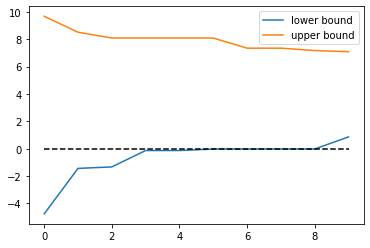

In [17]:
plt.plot(results['best_lowers'], label="lower bound")
plt.plot(results['best_uppers'], label="upper bound")
plt.plot((0,len(results['best_uppers'])-1), (0,0), color="black", linestyle="--")
plt.legend()
plt.show()